In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_data(seq_length, num_samples):
    X = []
    y = []
    for i in range(num_samples):
        x = np.linspace(i * 2 * np.pi, (i + 1) * 2 * np.pi, seq_length + 1)
        sine_wave = np.sin(x)
        X.append(sine_wave[:-1])
        y.append(sine_wave[1:])
    return np.array(X), np.array(y)

seq_length = 50
num_samples = 1000
X, y = generate_data(seq_length, num_samples)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

print(X.shape, y.shape)

torch.Size([1000, 50]) torch.Size([1000, 50])


In [3]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out
    
input_size = 1
hidden_size = 20
output_size = 1
model = SimpleRNN(input_size, hidden_size, output_size)

In [4]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X.unsqueeze(2))
    loss = criterion(outputs, y.unsqueeze(2))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.5884
Epoch [20/100], Loss: 0.4750
Epoch [30/100], Loss: 0.3725
Epoch [40/100], Loss: 0.2615
Epoch [50/100], Loss: 0.1557
Epoch [60/100], Loss: 0.1053
Epoch [70/100], Loss: 0.0780
Epoch [80/100], Loss: 0.0563
Epoch [90/100], Loss: 0.0424
Epoch [100/100], Loss: 0.0308


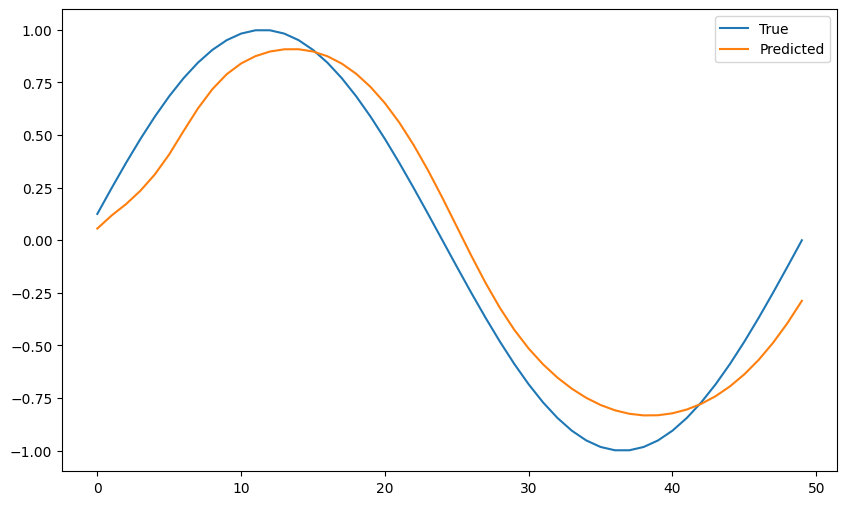

In [5]:
model.eval()
with torch.no_grad():
    predictions = model(X.unsqueeze(2)).squeeze(2).numpy()

plt.figure(figsize=(10, 6))
plt.plot(y[0].numpy(), label='True')
plt.plot(predictions[0], label='Predicted')
plt.legend()
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

In [2]:
url = "https://raw.githubusercontent.com/justmarkham/DAT8/master/data/sms.tsv"
df = pd.read_csv(url, delimiter='\t', header=None, names=['label', 'text'])

In [3]:
def preprocess_text(text):
    return text.lower().split()

df['text'] = df['text'].apply(preprocess_text)
df = df[['text', 'label']]

le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

vocab = set([word for phrase in train_data['text'] for word in phrase])

word_to_idx = {word: idx for idx, word in enumerate(vocab, 1)}

def encode_phrase(phrase):
    return [word_to_idx.get(word, 0) for word in phrase]

train_data['text'] = train_data['text'].apply(encode_phrase)
test_data['text'] = test_data['text'].apply(encode_phrase)

max_length = max(df['text'].apply(len))

def pad_sequence(seq, max_length):
    return seq + [0] * (max_length - len(seq))

train_data['text'] = train_data['text'].apply(lambda x: pad_sequence(x, max_length))
test_data['text'] = test_data['text'].apply(lambda x: pad_sequence(x, max_length))

In [4]:
class SentimentDataset(Dataset):
    def __init__(self, data):
        self.texts = data['text'].values
        self.labels = data['label'].values

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)
    
train_dataset = SentimentDataset(train_data)
test_dataset = SentimentDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embed_size, padding_idx=0)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
    
vocab_size = len(word_to_idx) + 1
embed_size = 128
hidden_size = 128
output_size = 2
model = SentimentRNN(vocab_size, embed_size, hidden_size, output_size)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for texts, labels in train_loader:
        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

Epoch [1/10], Loss: 0.4061
Epoch [2/10], Loss: 0.3973
Epoch [3/10], Loss: 0.3955
Epoch [4/10], Loss: 0.3957
Epoch [5/10], Loss: 0.3955
Epoch [6/10], Loss: 0.3938
Epoch [7/10], Loss: 0.3955
Epoch [8/10], Loss: 0.3952
Epoch [9/10], Loss: 0.3989
Epoch [10/10], Loss: 0.3962


In [7]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')


Accuracy: 86.64%


Epoch [1/10], Loss: 0.3947
Epoch [2/10], Loss: 0.3949
Epoch [3/10], Loss: 0.3954
Epoch [4/10], Loss: 0.3946
Epoch [5/10], Loss: 0.3942
Epoch [6/10], Loss: 0.3948
Epoch [7/10], Loss: 0.3970
Epoch [8/10], Loss: 0.3931
Epoch [9/10], Loss: 0.3942
Epoch [10/10], Loss: 0.3937


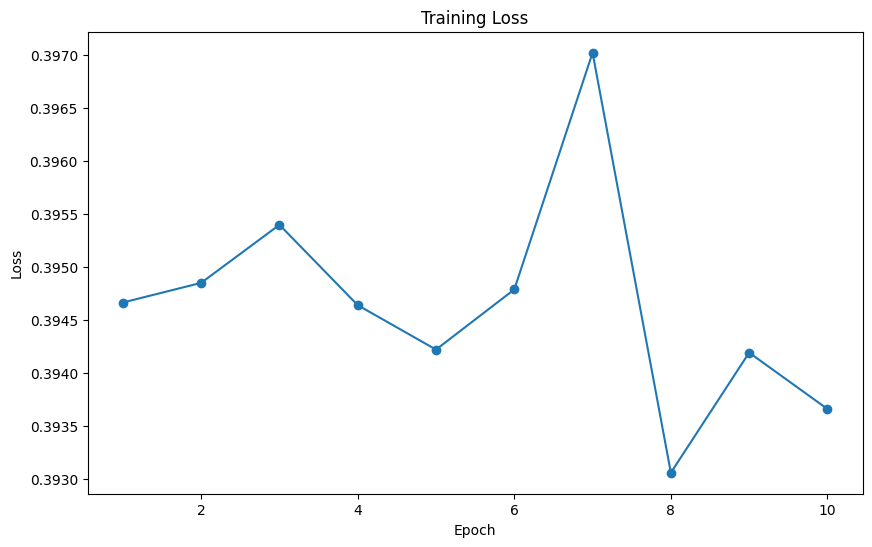

In [8]:
losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for texts, labels in train_loader:
        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    losses.append(epoch_loss / len(train_loader))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()